# **Project guideline**

## **Project Proposal**
For this project, I aim to understand the performance of different countries or regions (NOC) in specific sports over time, the evolution of their participation in the Olympic Games, and the patterns or trends in athletes’ performance related to factors such as age, height, and weight.

## **Questions:**
**Q1:** Which countries or regions (NOC) have had better performance in specific sports over time? </br>
**Q2:** How has the participation of different countries and regions (NOC) in the Olympic Games evolved over the years, and how does their performance compare to each other? </br>
**Q3:** Are there patterns or trends in athletes, performance related to factors such as age, height, and weight?

## **Initial Hypotheses:**
**H1:** Certain countries/regions have consistently dominated in specific sports due to cultural factors, sports programs, and geographical conditions. </br>
**H2:** Athletes in strength and endurance sports tend to be in an optimal age and physical characteristics range. </br>
**H3:** The participation of developing countries/regions has increased in recent decades, showing greater diversity in the Olympic Games. </br>
**H4:** There is a positive correlation between optimal physical characteristics (height, weight) and success in certain sports.

### **01. Which client/dataset did you select and why?**
I selected the Client 3: SportsStats (Olympics Dataset - 120 years of data)

SportsStats is a sports analysis firm partnering with local news and elite personal trainers to provide “interesting” insights to help their partners. Insights could be patterns/trends highlighting certain groups/events/countries, etc. for the purpose of developing a news story or discovering key health insights.

I chose this dataset due to the smaller file size compared to the other options.

### **02. Describe the steps you took to import and clean the data.**
As the data is available in a CSV file, I imported it into a Notebook to perform my first analyzes using Python. To perform the cleanup I removed duplicate values, to understand the number of athletes involved in the games, and also some of the empty values.

![Texto alternativo](ERD.png)

### **03. Initial EDA**

In [26]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab_Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks


In [27]:
noc_region = pd.read_csv('noc_regions.csv')
athletes = pd.read_csv('athlete_events.csv')

In [28]:
!pip install pandasql

In [29]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [32]:
# Merge data
data = pd.merge(athletes, noc_region, how='left', left_on='NOC', right_on='NOC')

## Q1: Which countries or regions (NOC) have had better performance in specific sports over time?


In [33]:
# Numerical values for each medal
medal_values = {'Gold': 3, 'Silver': 2, 'Bronze': 1}

# Group and calculate by NOC
medal_score = data.groupby(['NOC', 'Sport', 'Medal'])['Medal'].count().reset_index(name='Count')
medal_score['Score'] = medal_score['Medal'].map(medal_values) * medal_score['Count']

medal_score_total = medal_score.groupby(['NOC', 'Sport'])['Score'].sum().reset_index()

# Identify NOC whit highest score by sport
top_noc_per_sport_score = medal_score_total.loc[medal_score_total.groupby('Sport')['Score'].idxmax()]
top_noc_per_sport_score = top_noc_per_sport_score.sort_values(by='Score', ascending=False)

# Erase index column
top_noc_per_sport_score.reset_index(drop=True, inplace=True)

print("Based score view:")
print(top_noc_per_sport_score)
#print("\n")


# Now view for each kind of medal
medal_count = medal_score.pivot_table(index=['NOC', 'Sport'], columns='Medal', values='Count', fill_value=0).reset_index()
medal_count = medal_count[['NOC', 'Sport', 'Gold', 'Silver', 'Bronze']]

medal_count = medal_count.sort_values(by='Gold', ascending=False)

medal_count.reset_index(drop=True, inplace=True)

print("View based on number of medals by type:")
#print(medal_count.head())
medal_count

Based score view:
    NOC          Sport  Score
0   USA       Swimming   2630
1   USA      Athletics   2481
2   USA     Basketball    927
3   CAN     Ice Hockey    881
4   USA         Rowing    848
..  ...            ...    ...
61  GBR      Triathlon     10
62  USA          Roque      6
63  ESP  Basque Pelota      6
64  GBR   Jeu De Paume      3
65  SUI    Aeronautics      3

[66 rows x 3 columns]
View based on number of medals by type:


Medal,NOC,Sport,Gold,Silver,Bronze
0,USA,Swimming,649,254,175
1,USA,Athletics,542,317,221
2,USA,Basketball,281,24,36
3,CAN,Ice Hockey,220,93,35
4,USA,Rowing,186,101,88
...,...,...,...,...,...
1444,JPN,Fencing,0,5,0
1445,JPN,Football,0,18,16
1446,JPN,Hockey,0,11,0
1447,JPN,Sailing,0,2,2


# Q2: How has the participation of different countries and regions (NOC) in the Olympic Games evolved over the years, and how does their performance compare to each other?

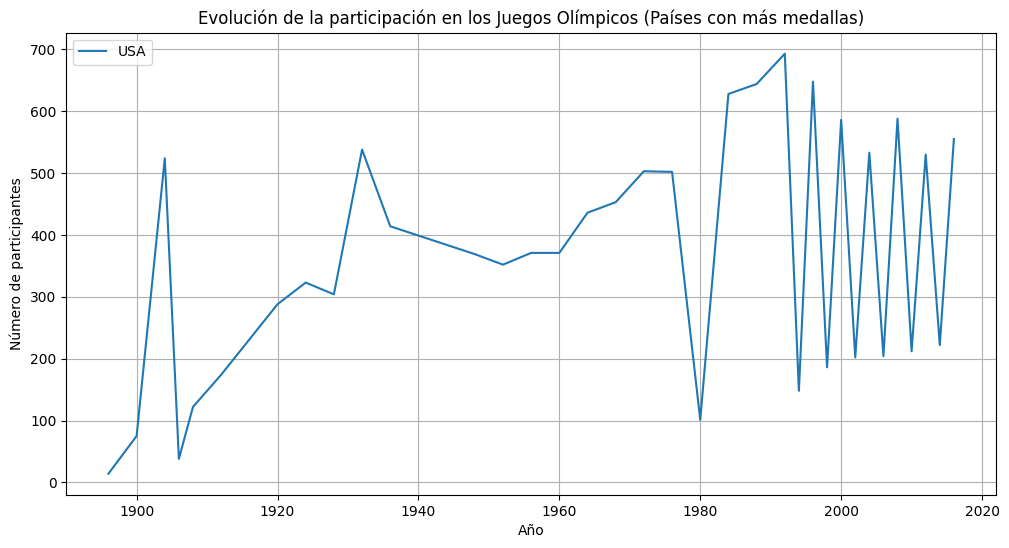

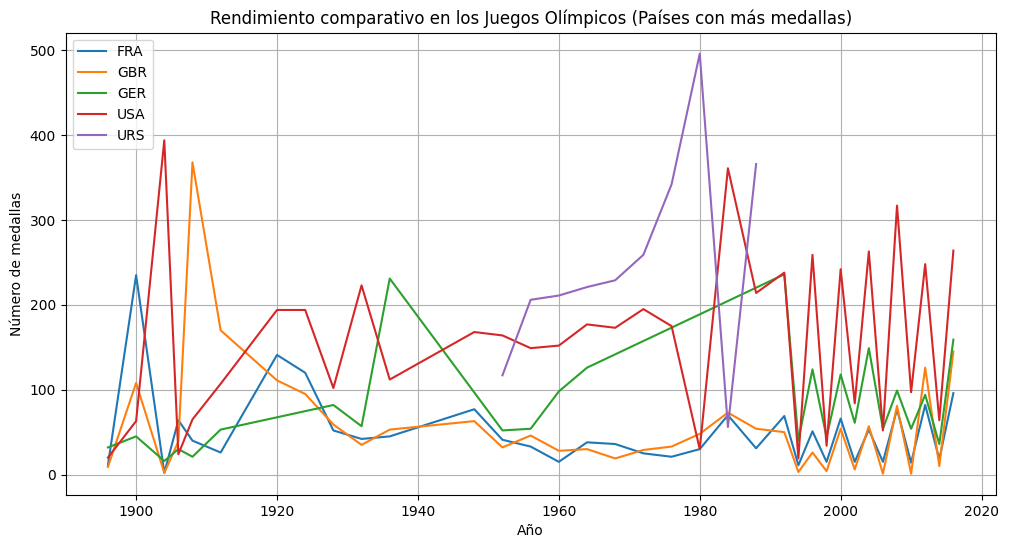

In [34]:
# Analysis of participation evolution
participation_evolution = data.groupby(['Year', 'region'])['ID'].nunique().reset_index()
participation_evolution.rename(columns={'ID': 'Participants'}, inplace=True)

# Performance analysis: Count medals by country, year, and medal type
medal_recount = data.groupby(['Year', 'NOC', 'Medal'])['ID'].count().reset_index()

# Sum medals by country and year
medal_recount['Medal_Count'] = medal_recount.groupby(['Year', 'NOC'])['ID'].transform('sum')

# Select only rows with medals
medal_recount = medal_recount[medal_recount['Medal'].notnull()]

# Drop duplicates and keep only one row per country and year
medal_recount = medal_recount.drop_duplicates(subset=['Year', 'NOC'])

noc_continent = noc_region[['NOC', 'region']].drop_duplicates()
medal_recount = pd.merge(medal_recount, noc_continent, how='left', on='NOC')

# Select countries or regions with the highest total number of medals
top_countries = medal_recount.groupby('NOC')['Medal_Count'].sum().nlargest(5).index.tolist()

# Filter data to include only selected countries
participation_evolution_filtered = participation_evolution[participation_evolution['region'].isin(top_countries)]
medal_count_filtered = medal_recount[medal_recount['NOC'].isin(top_countries)]

# Display
plt.figure(figsize=(12, 6))
for region in participation_evolution_filtered['region'].unique():
    plt.plot(participation_evolution_filtered[participation_evolution_filtered['region'] == region]['Year'],
             participation_evolution_filtered[participation_evolution_filtered['region'] == region]['Participants'],
             label=region)
plt.title('Evolución de la participación en los Juegos Olímpicos (Países con más medallas)')
plt.xlabel('Año')
plt.ylabel('Número de participantes')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for noc in medal_count_filtered['NOC'].unique():
    plt.plot(medal_count_filtered[medal_count_filtered['NOC'] == noc]['Year'],
             medal_count_filtered[medal_count_filtered['NOC'] == noc]['Medal_Count'],
             label=noc)
plt.title('Rendimiento comparativo en los Juegos Olímpicos (Países con más medallas)')
plt.xlabel('Año')
plt.ylabel('Número de medallas')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


Select an option:
1. View total history by country.
2. Filter by country and sport.
Enter the number of the option you want: 2
Enter the country code (NOC): USA
Enter the sport: Swimming


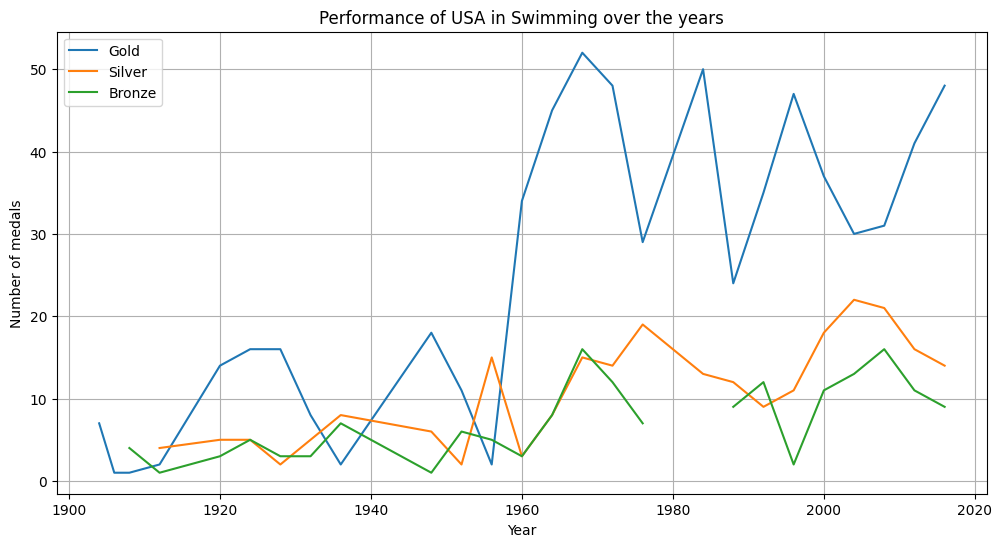

In [35]:
# Main menu
print("Select an option:")
print("1. View total history by country.")
print("2. Filter by country and sport.")
option = input("Enter the number of the option you want: ")

if option == '1':
    # Option to view performance over the years of a country
    country_input = input("Enter the country code (NOC) to view its performance over the years: ")
    if country_input in medal_recount['NOC'].unique():
        country_data = medal_recount[medal_recount['NOC'] == country_input]
        if not country_data.empty:
            plt.figure(figsize=(12, 6))
            plt.plot(country_data['Year'], country_data['Medal_Count'])
            plt.title(f'Performance of {country_input} in the Olympic Games over the years')
            plt.xlabel('Year')
            plt.ylabel('Number of medals')
            plt.grid(True)
            plt.show()
        else:
            print("There are no medal data for this country in the database.")
    else:
        print("The entered country is not in the database.")

elif option == '2':
    # Option to filter by country and sport
    country_input = input("Enter the country code (NOC): ")
    sport_input = input("Enter the sport: ")
    if country_input in medal_recount['NOC'].unique() and sport_input in data['Sport'].unique():
        country_sport_data = data[(data['NOC'] == country_input) & (data['Sport'] == sport_input)]
        if not country_sport_data.empty:
            # Check for medals before plotting the graph
            if 'Year' in country_sport_data.columns:
                gold_data = country_sport_data[country_sport_data['Medal'] == 'Gold'].groupby('Year')['ID'].count()
                silver_data = country_sport_data[country_sport_data['Medal'] == 'Silver'].groupby('Year')['ID'].count()
                bronze_data = country_sport_data[country_sport_data['Medal'] == 'Bronze'].groupby('Year')['ID'].count()

                # Combine data series into a DataFrame
                medal_count_country_sport = pd.DataFrame({'Gold': gold_data, 'Silver': silver_data, 'Bronze': bronze_data}).reset_index()

                plt.figure(figsize=(12, 6))
                plt.plot(medal_count_country_sport['Year'], medal_count_country_sport['Gold'], label='Gold')
                plt.plot(medal_count_country_sport['Year'], medal_count_country_sport['Silver'], label='Silver')
                plt.plot(medal_count_country_sport['Year'], medal_count_country_sport['Bronze'], label='Bronze')
                plt.title(f'Performance of {country_input} in {sport_input} over the years')
                plt.xlabel('Year')
                plt.ylabel('Number of medals')
                plt.legend(loc='upper left')
                plt.grid(True)
                plt.show()
            else:
                print("There are no medal data for this country and sport in the database.")
        else:
            print("There are no medal data for this country and sport in the database.")
    else:
        print("The entered data is not in the database.")

else:
    print("Invalid option.")


# Q3: Are there patterns or trends in athletes’ performance related to factors such as age, height, and weight?



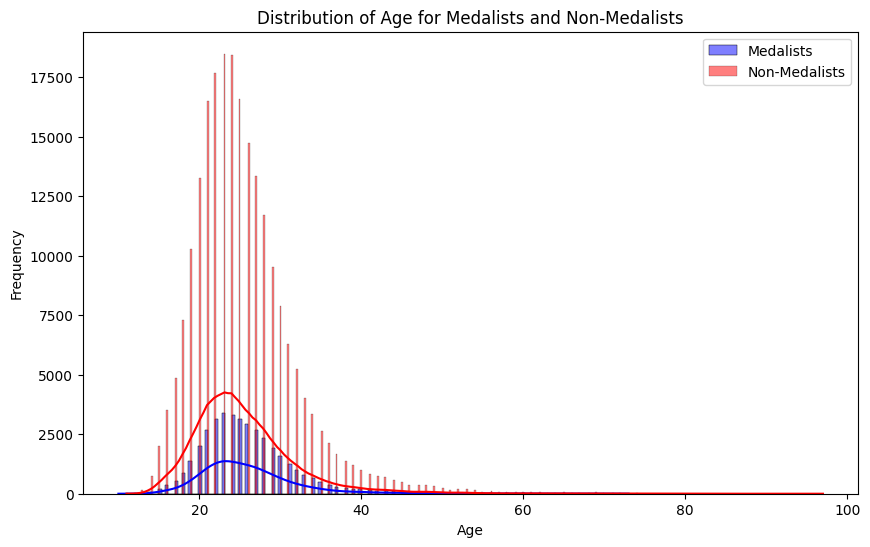

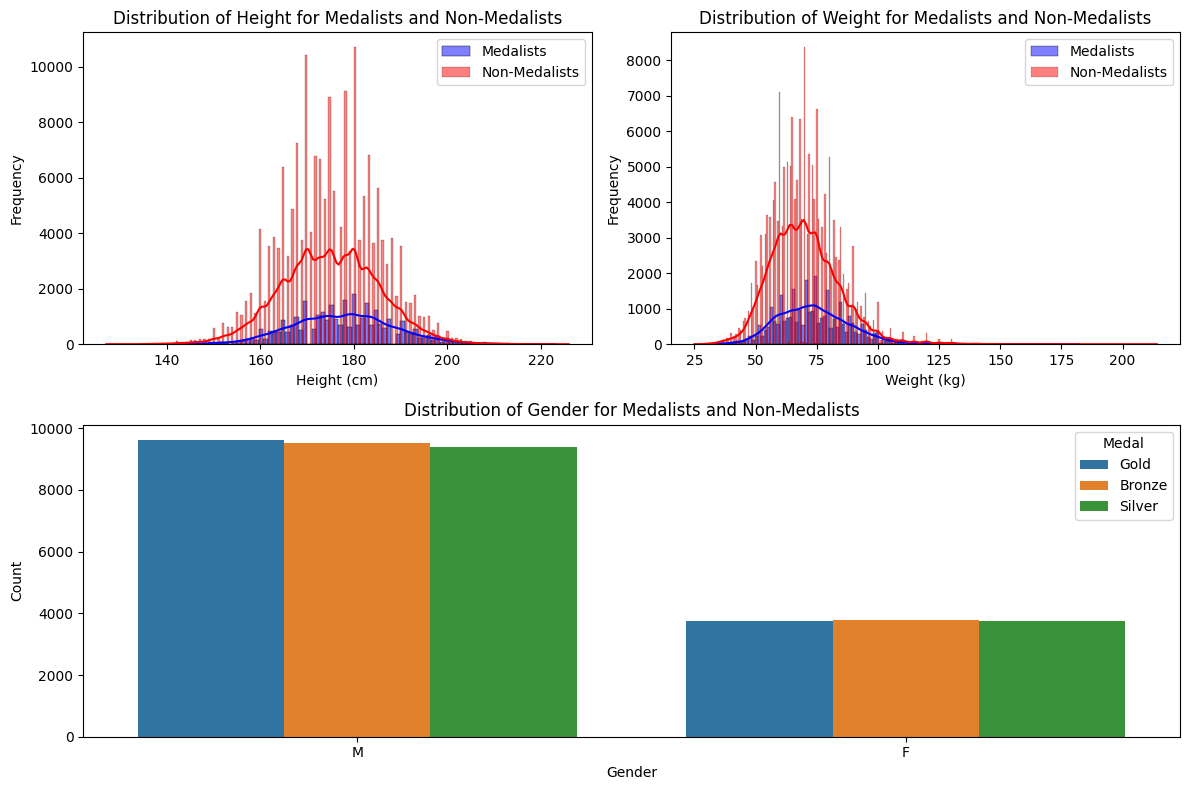

In [36]:
# Filter the data for athletes who won medals and those who did not
medalists = data[data['Medal'].isin([1, 'Gold', 'Silver', 'Bronze'])]
non_medalists = data[~data['Medal'].isin([1, 'Gold', 'Silver', 'Bronze'])]

# Visualize the distribution of age for athletes who won medals and those who did not
plt.figure(figsize=(10, 6))
sns.histplot(data=medalists, x='Age', kde=True, color='blue', label='Medalists', alpha=0.5)
sns.histplot(data=non_medalists, x='Age', kde=True, color='red', label='Non-Medalists', alpha=0.5)
plt.title('Distribution of Age for Medalists and Non-Medalists')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# Visualize the distribution of height for athletes who won medals and those who did not
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(data=medalists, x='Height', kde=True, color='blue', label='Medalists', alpha=0.5)
sns.histplot(data=non_medalists, x='Height', kde=True, color='red', label='Non-Medalists', alpha=0.5)
plt.title('Distribution of Height for Medalists and Non-Medalists')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.legend()

# Visualize the distribution of weight for athletes who won medals and those who did not
plt.subplot(2, 2, 2)
sns.histplot(data=medalists, x='Weight', kde=True, color='blue', label='Medalists', alpha=0.5)
sns.histplot(data=non_medalists, x='Weight', kde=True, color='red', label='Non-Medalists', alpha=0.5)
plt.title('Distribution of Weight for Medalists and Non-Medalists')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.legend()

# Visualize the distribution of gender for athletes who won medals and those who did not
plt.subplot(2, 1, 2)
sns.countplot(data=data, x='Sex', hue='Medal')
plt.title('Distribution of Gender for Medalists and Non-Medalists')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Medal', loc='upper right')

plt.tight_layout()
plt.show()


In [65]:
def analyze_sport_performance(data, sport):

    # Filter the data for the specified sport
    sport_data = data[data['Sport'] == sport]

    # Create a subplot of 2x2
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots

    # Title for the entire set of plots
    fig.suptitle(f"Data records for: {sport}", fontsize=16)

    # Create a legend for medal types
    gold_patch = Patch(facecolor='gold', edgecolor='k', label='Gold')
    silver_patch = Patch(facecolor='silver', edgecolor='k', label='Silver')
    bronze_patch = Patch(facecolor='#CD7F32', edgecolor='k', label='Bronze')
    plt.legend(handles=[gold_patch, silver_patch, bronze_patch], title='Medal Type', loc='upper left', fontsize=12)

    # Visualize the distribution of age for athletes who won medals and those who did not
    ax = axes[0, 0]
    sns.histplot(data=sport_data, x='Age', hue='Medal', kde=True, multiple="stack", ax=ax)
    ax.set_title('Age Distribution for Medal Winners', fontsize=14)
    ax.set_xlabel('Age', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    legend_entries = [Patch(facecolor='b', edgecolor='k', label='Medal Winners'),
                      Patch(facecolor='r', edgecolor='k', label='Non-Winners')]
    plt.legend(handles=legend_entries, title='Medal', loc='upper right', fontsize=12)

    # Visualize the distribution of height for athletes who won medals and those who did not
    ax = axes[0, 1]
    sns.histplot(data=sport_data, x='Height', hue='Medal', kde=True, multiple="stack", ax=ax)
    ax.set_title('Height Distribution for Medal Winners', fontsize=14)
    ax.set_xlabel('Height (cm)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    plt.legend(handles=legend_entries, title='Medal', loc='upper right', fontsize=12)

    # Visualize the distribution of weight for athletes who won medals and those who did not
    ax = axes[1, 0]
    sns.histplot(data=sport_data, x='Weight', hue='Medal', kde=True, multiple="stack", ax=ax)
    ax.set_title('Weight Distribution for Medal Winners', fontsize=14)
    ax.set_xlabel('Weight (kg)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    plt.legend(handles=legend_entries, title='Medal', loc='upper right', fontsize=12)

    # Visualize the distribution of gender for athletes who won medals and those who did not
    ax = axes[1, 1]
    sns.countplot(data=sport_data, x='Sex', hue='Medal', ax=ax)
    ax.set_title('Gender Distribution for Medal Winners', fontsize=14)
    ax.set_xlabel('Gender', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='Medal', loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()



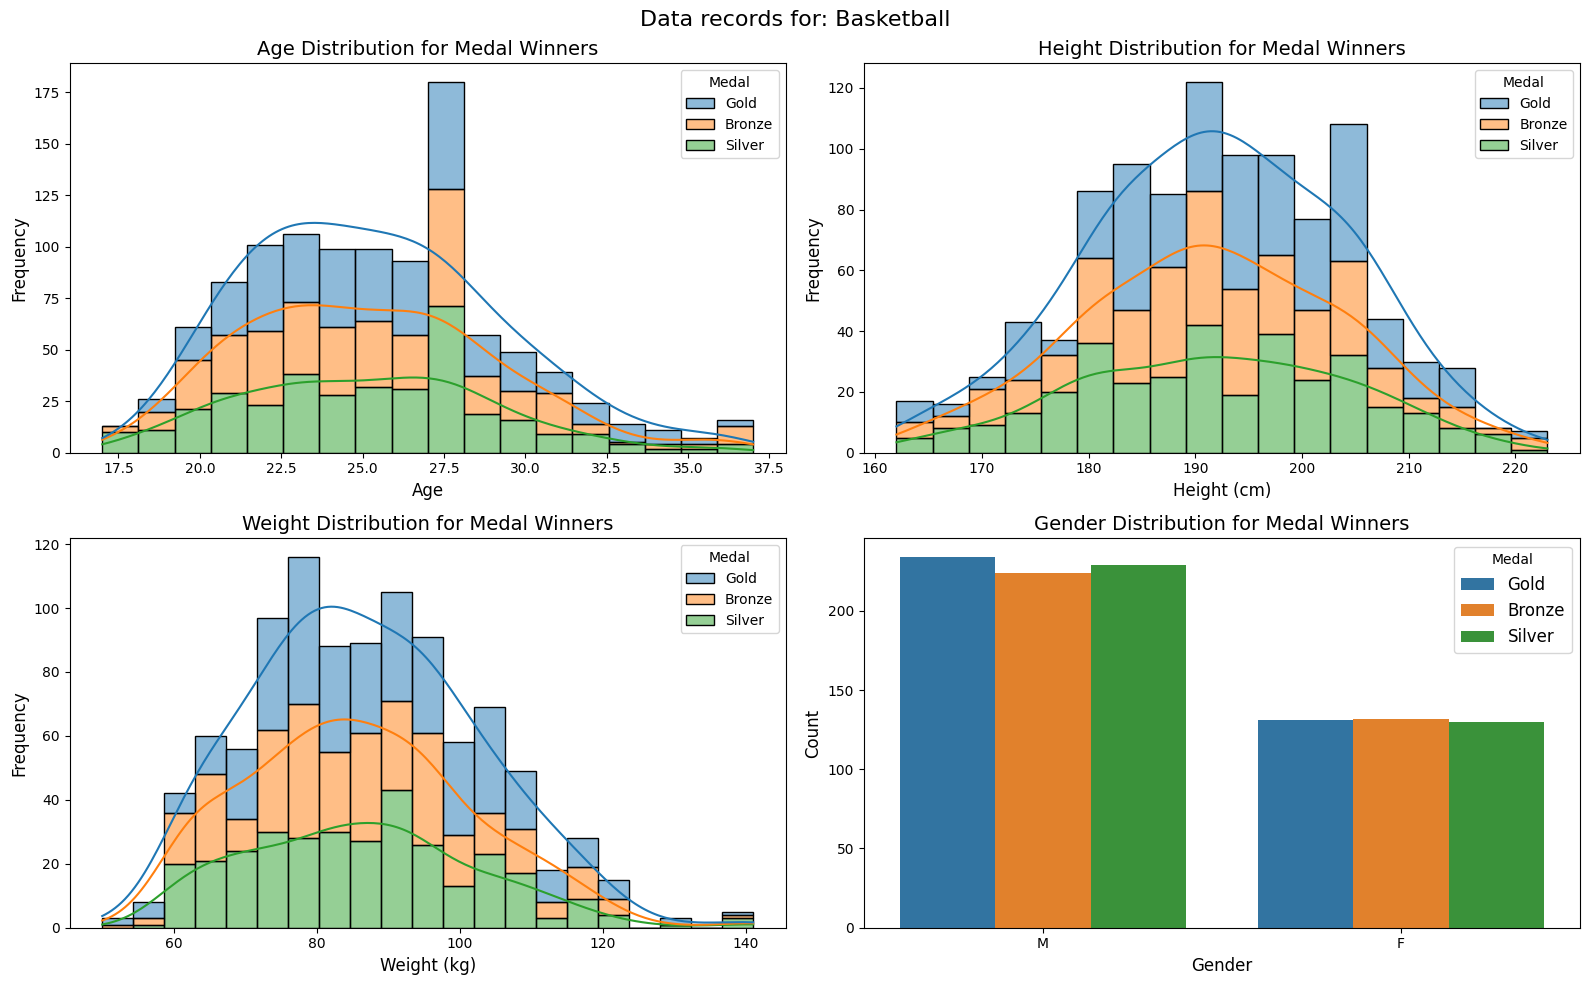

In [66]:
# Insert the sport to analise

analyze_sport_performance(data, 'Basketball')